<a href="https://colab.research.google.com/github/mgmgc/AD-IA/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyod

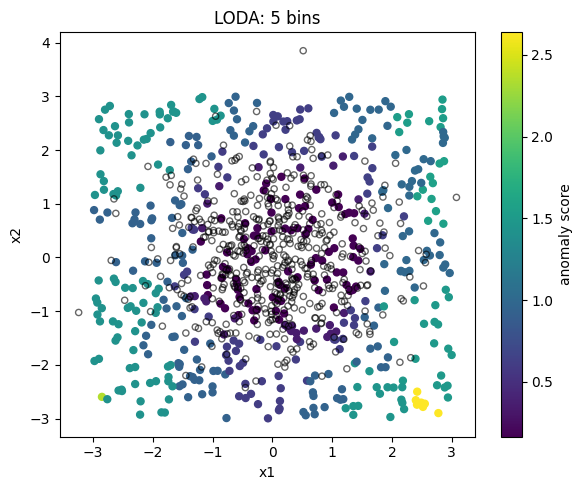

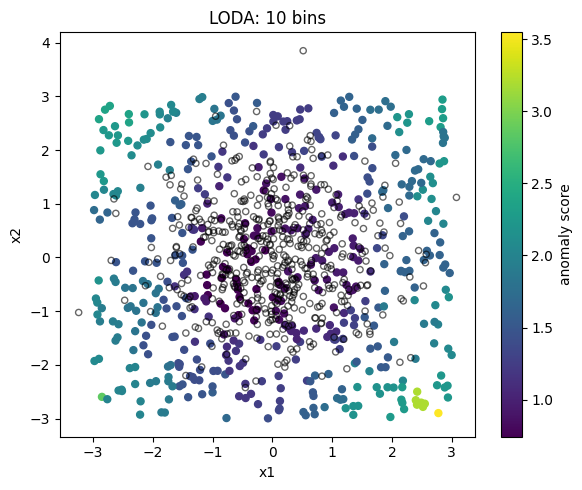

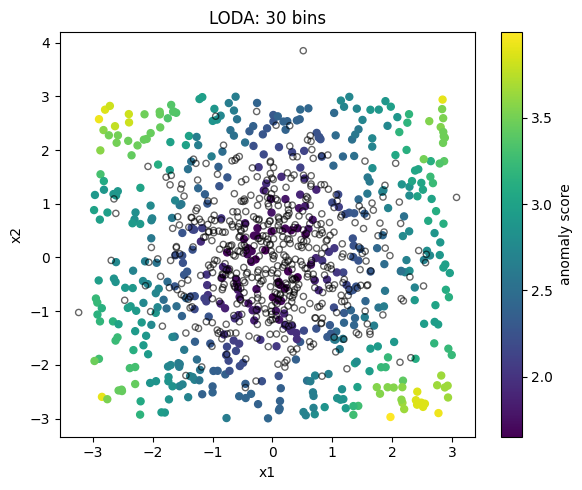

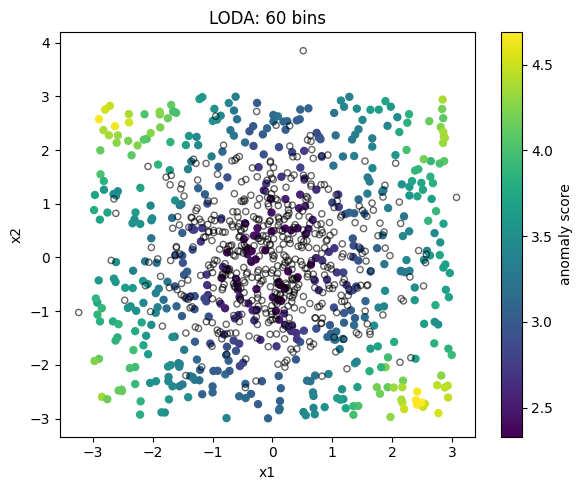

bins=5: mean_prob=4.611e-01, median=3.932e-01, frac_zero=0.000
bins=10: mean_prob=2.435e-01, median=2.272e-01, frac_zero=0.000
bins=30: mean_prob=8.190e-02, median=7.120e-02, frac_zero=0.000
bins=60: mean_prob=4.095e-02, median=3.600e-02, frac_zero=0.000


In [2]:
# ex1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

np.random.seed(0)
X_train, _ = make_blobs(n_samples=500, centers=[(0,0)], cluster_std=1.0, random_state=42)

V = np.random.multivariate_normal([0,0], np.eye(2), size=5)
V = V / np.linalg.norm(V, axis=1, keepdims=True)

proj_train = [X_train.dot(v) for v in V]
all_proj = np.hstack(proj_train)

minp, maxp = all_proj.min(), all_proj.max()
margin = max(1.0, 0.5*(maxp-minp))
hist_range = (minp-margin, maxp+margin)

X_test = np.random.uniform(-3, 3, (500,2))

def calc_scores(n_bins):
    probs_test = np.zeros((len(X_test), len(V)))
    for i, v in enumerate(V):
        counts, edges = np.histogram(proj_train[i], bins=n_bins, range=hist_range)
        p = counts.astype(float) / (counts.sum()+1e-12)
        vals = X_test.dot(v)
        inds = np.digitize(vals, edges) - 1
        oob = (inds < 0) | (inds >= len(p))
        inds = np.clip(inds, 0, len(p)-1)
        pv = p[inds]
        pv[oob] = 0.0
        probs_test[:, i] = pv
    mean_p = probs_test.mean(axis=1)
    return mean_p

bins_list = [5, 10, 30, 60]
for b in bins_list:
    mean_p = calc_scores(b)
    score = -np.log(mean_p + 1e-12)
    plt.figure(figsize=(6,5))
    sc = plt.scatter(X_test[:,0], X_test[:,1], c=score, cmap='viridis', s=25)
    plt.colorbar(sc, label='anomaly score')
    plt.scatter(X_train[:,0], X_train[:,1], facecolors='none', edgecolors='k', s=20, alpha=0.6)
    plt.title(f"LODA: {b} bins")
    plt.xlabel('x1'); plt.ylabel('x2')
    plt.tight_layout()
plt.show()

for b in bins_list:
    mp = calc_scores(b)
    print(f"bins={b}: mean_prob={mp.mean():.3e}, median={np.median(mp):.3e}, frac_zero={(mp==0).mean():.3f}")


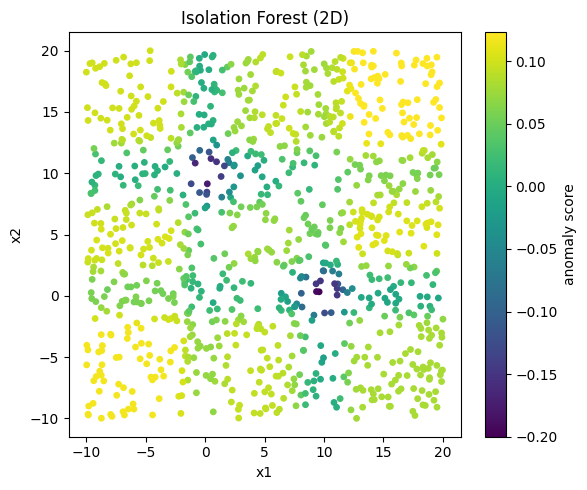

In [3]:
#ex 2.1, 2.2, 2.3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from pyod.models.iforest import IForest

X_train, y_train = make_blobs(
    n_samples=[500, 500],
    centers=[(10, 0), (0, 10)],
    cluster_std=1.0,
    random_state=42
)
iforest = IForest(contamination=0.02, random_state=42)
iforest.fit(X_train)

X_test = np.random.uniform(-10, 20, size=(1000, 2))

scores_test = iforest.decision_function(X_test)

plt.figure(figsize=(6, 5))
sc = plt.scatter(X_test[:, 0], X_test[:, 1],
                 c=scores_test, cmap='viridis', s=15)
plt.colorbar(sc, label='anomaly score')
plt.title("Isolation Forest (2D)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()

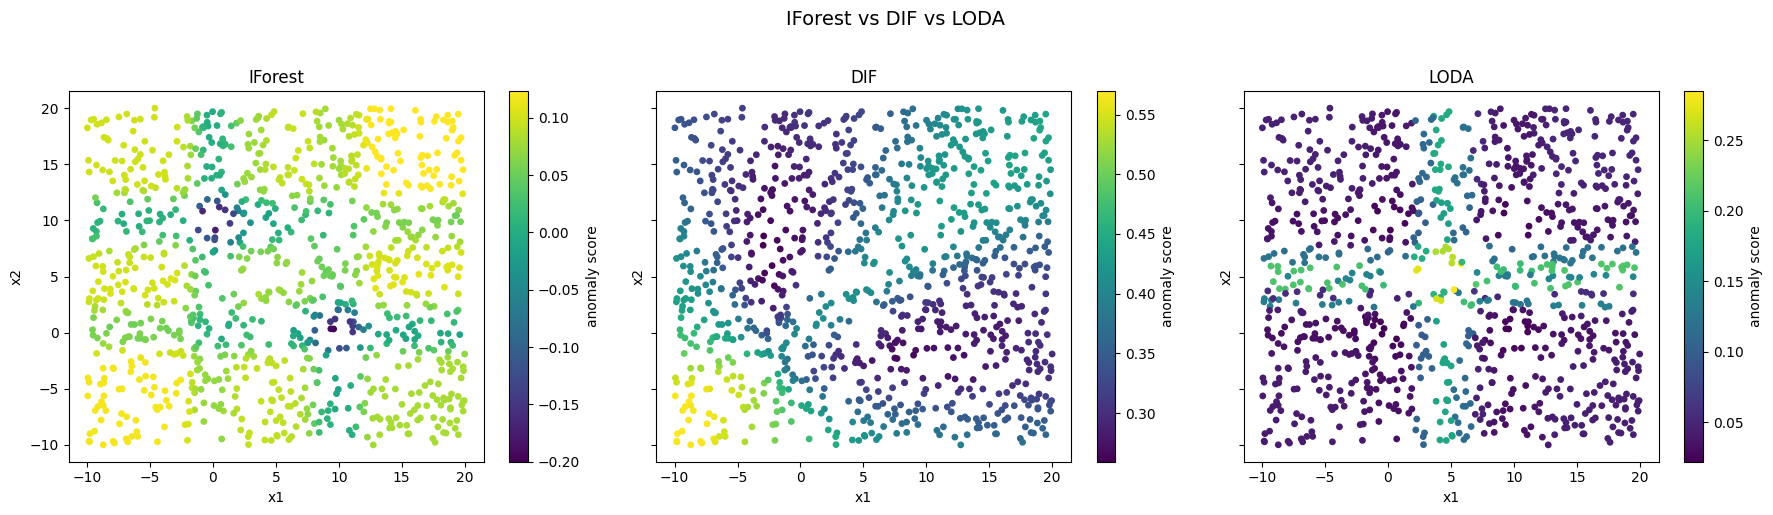

In [4]:
#2.4
from pyod.models.dif import DIF
from pyod.models.loda import LODA
import warnings
warnings.filterwarnings("ignore")

iforest = IForest(contamination=0.02, random_state=42)
iforest.fit(X_train)
scores_if = iforest.decision_function(X_test)

dif = DIF(hidden_neurons=[32, 16], contamination=0.02, random_state=42)
dif.fit(X_train)
scores_dif = dif.decision_function(X_test)

loda = LODA(contamination=0.02, n_bins=20)
loda.fit(X_train)
scores_loda = loda.decision_function(X_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

models = [
    ("IForest", scores_if),
    ("DIF", scores_dif),
    ("LODA", scores_loda)
]

for ax, (name, scores) in zip(axes, models):
    sc = ax.scatter(X_test[:, 0], X_test[:, 1],
                    c=scores, cmap='viridis', s=15)
    ax.set_title(name)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    plt.colorbar(sc, ax=ax, label="anomaly score")

plt.suptitle("IForest vs DIF vs LODA", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

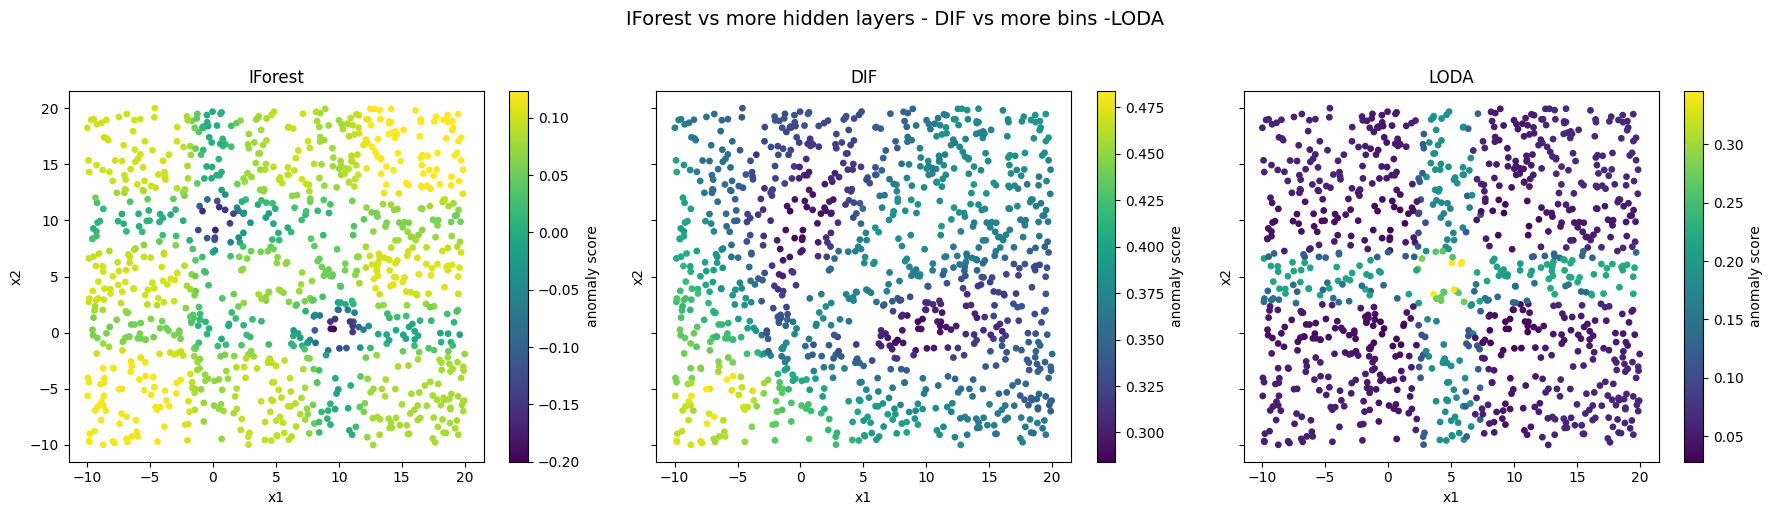

In [5]:
#2.5
from pyod.models.dif import DIF
from pyod.models.loda import LODA
import warnings
warnings.filterwarnings("ignore")

iforest = IForest(contamination=0.02, random_state=42)
iforest.fit(X_train)
scores_if = iforest.decision_function(X_test)

dif = DIF(hidden_neurons=[128, 128, 32, 16], contamination=0.02, random_state=42)
dif.fit(X_train)
scores_dif = dif.decision_function(X_test)

loda = LODA(contamination=0.02, n_bins=50)
loda.fit(X_train)
scores_loda = loda.decision_function(X_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

models = [
    ("IForest", scores_if),
    ("DIF", scores_dif),
    ("LODA", scores_loda)
]

for ax, (name, scores) in zip(axes, models):
    sc = ax.scatter(X_test[:, 0], X_test[:, 1],
                    c=scores, cmap='viridis', s=15)
    ax.set_title(name)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    plt.colorbar(sc, ax=ax, label="anomaly score")

plt.suptitle("IForest vs more hidden layers - DIF vs more bins -LODA", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

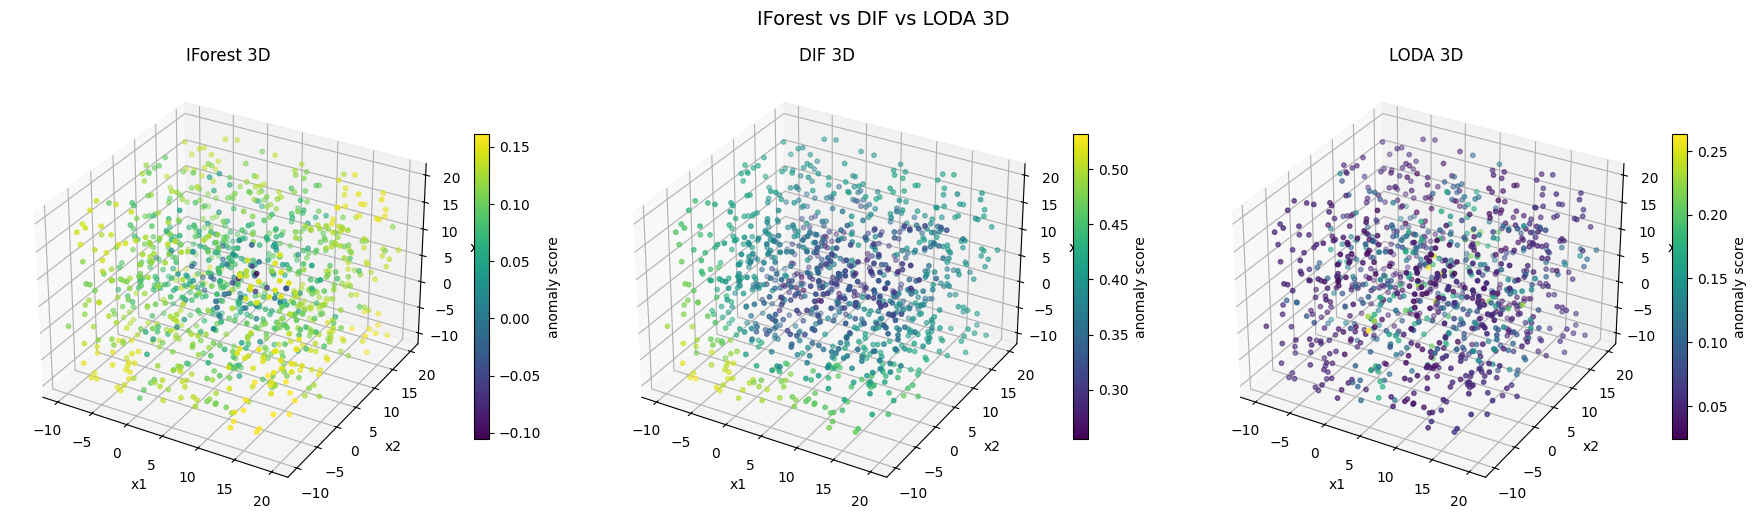

In [6]:

#2.6
warnings.filterwarnings("ignore")

np.random.seed(42)

X_train_3d, y_train_3d = make_blobs(
    n_samples=[500, 500],
    centers=[(0, 10, 0), (10, 0, 10)],
    cluster_std=1.0,
    random_state=42
)

X_test_3d = np.random.uniform(-10, 20, size=(1000, 3))

iforest_3d = IForest(contamination=0.02, random_state=42)
iforest_3d.fit(X_train_3d)
scores_if_3d = iforest_3d.decision_function(X_test_3d)

dif_3d = DIF(hidden_neurons=[32, 16], contamination=0.02, random_state=42)
dif_3d.fit(X_train_3d)
scores_dif_3d = dif_3d.decision_function(X_test_3d)
loda_3d = LODA(contamination=0.02, n_bins=20)
loda_3d.fit(X_train_3d)
scores_loda_3d = loda_3d.decision_function(X_test_3d)

fig = plt.figure(figsize=(18, 5))

models_3d = [
    ("IForest 3D", scores_if_3d),
    ("DIF 3D", scores_dif_3d),
    ("LODA 3D", scores_loda_3d)
]

for i, (name, scores) in enumerate(models_3d, start=1):
    ax = fig.add_subplot(1, 3, i, projection='3d')

    p = ax.scatter(
        X_test_3d[:, 0], X_test_3d[:, 1], X_test_3d[:, 2],
        c=scores, cmap='viridis', s=10
    )

    ax.set_title(name)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    fig.colorbar(p, ax=ax, shrink=0.7, label="anomaly score")

plt.suptitle("IForest vs DIF vs LODA 3D", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


In [7]:
import scipy.io as sio
data = sio.loadmat('shuttle.mat')

In [8]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Apr 26 18:16:23 2016',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 50,  21,  77, ...,  27,  48,  22],
        [ 53,   0,  82, ...,  29,  30,   2],
        [ 37,   0,  76, ...,  40,  48,   8],
        ...,
        [ 49,   0,  87, ...,  38,  41,   2],
        [ 80,   0,  84, ...,   4, 120, 116],
        [ 37,   0, 103, ...,  66,  85,  20]], dtype=int16),
 'y': array([[1],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]], dtype=uint8)}

In [9]:
#3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

X = data['X']
y = data['y'].ravel()

y_bin = (y != 1).astype(int)

models = {
    'IForest': lambda: IForest(contamination=0.02, random_state=42),
    'LODA':    lambda: LODA(contamination=0.02, n_bins=20),
}

n_splits = 10
results = {name: {'ba': [], 'auc': []} for name in models}

for seed in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_bin, test_size=0.4, random_state=seed, stratify=y_bin
    )
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_test_n  = scaler.transform(X_test)

    for name, model_fn in models.items():
        clf = model_fn()
        clf.fit(X_train_n)
        y_pred = clf.predict(X_test_n)
        scores = clf.decision_function(X_test_n)
        ba = balanced_accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, scores)
        results[name]['ba'].append(ba)
        results[name]['auc'].append(auc)

for name in models:
    mean_ba  = np.mean(results[name]['ba'])
    mean_auc = np.mean(results[name]['auc'])

    print(f"\nModel: {name}")
    print(f"  Balanced Accuracy: {mean_ba:.4f}")
    print(f"  ROC AUC:           {mean_auc:.4f}")



Model: IForest
  Balanced Accuracy: 0.3580
  ROC AUC:           0.0026

Model: LODA
  Balanced Accuracy: 0.4179
  ROC AUC:           0.2118


In [10]:
#3 DIF, 2 hidden layers, n_splits = 2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

X = data['X']
y = data['y'].ravel()

y_bin = (y != 1).astype(int)

models = {
    'DIF':    lambda: DIF(hidden_neurons=[8, 4], contamination=0.02, random_state=42, batch_size = 1024)
}

n_splits = 2
results = {name: {'ba': [], 'auc': []} for name in models}

for seed in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_bin, test_size=0.4, random_state=seed, stratify=y_bin
    )
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_test_n  = scaler.transform(X_test)

    for name, model_fn in models.items():
        clf = model_fn()
        clf.fit(X_train_n)
        y_pred = clf.predict(X_test_n)
        scores = clf.decision_function(X_test_n)
        ba = balanced_accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, scores)
        results[name]['ba'].append(ba)
        results[name]['auc'].append(auc)

for name in models:
    mean_ba  = np.mean(results[name]['ba'])
    mean_auc = np.mean(results[name]['auc'])

    print(f"\nModel: {name}")
    print(f"  Balanced Accuracy: {mean_ba:.4f}")
    print(f"  ROC AUC:           {mean_auc:.4f}")



Model: DIF
  Balanced Accuracy: 0.4970
  ROC AUC:           0.0255
